In [1]:
%pip install -qU --upgrade boto3
%pip install -qU --upgrade sagemaker

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from time import gmtime, strftime

In [3]:
role = get_execution_role()
sess = sagemaker.Session() 
region = sess.boto_session.region_name
bucket = sess.default_bucket()
print("The role is ", role)
print("The session is ", sess)
print("The region is ", region)
print("The bucket is ", bucket)

The role is  arn:aws:iam::528179355484:role/LabRole
The session is  <sagemaker.session.Session object at 0x7f05405f8110>
The region is  us-east-1
The bucket is  sagemaker-us-east-1-528179355484


In [4]:
# Define the headers accordign to the despcription provided

columns = ['Close','Day','Next Close','Volume','mom','mom1','mom2','mom3','ROC_5','ROC_10','ROC_15','ROC_20','EMA_10','EMA_20','EMA_50','DTB4WK','DTB3','DTB6','DGS5','DGS10','Oil','Gold','DAAA','DBAA','AAPL','AMZN','GE','JNJ','JPM','MSFT','WFC','XOM','FCHI','FTSE','GDAXI','DJI','HSI','IXIC','SSEC','RUT','NYSE','TE1','TE2','TE3','TE5','TE6','DE1','DE2','DE4','DE5','DE6','CTB3M','CTB6M','CTB1Y','AUD','Brent','CAC-F','copper-F','WIT-oil','DAX-F','DJI-F','EUR','FTSE-F','gold-F','HSI-F','KOSPI-F','NASDAQ-F','GAS-F','Nikkei-F','NZD','silver-F','RUSSELL-F','S&P-F','CHF','Dollar index-F','Dollar index','wheat-F','XAG','XAU']

# Load the dataset into a DataFrame usign whitespace as the delimiter. Make sure to tell it that the first row is not the header and include the column names we want to use

market_data=pd.read_csv('Processed_S&P.csv', sep=',', names=columns, header=0)

In [5]:
market_data.head()

,Close,Day,Next Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
0,1159.459961,0,1166.209961,0.049389,0.007779,0.000452,-0.000217,0.004042,1.666887,3.679651,...,1.35,1.46,0.77,0.80,-0.62,-0.21,-0.62,1.83,2.11,1.50
1,1166.209961,1,1165.829956,0.135803,0.005822,0.007779,0.000452,-0.000217,1.798167,4.238501,...,0.21,0.98,0.49,0.54,-0.09,-0.19,-0.14,1.74,0.40,-0.06
2,1165.829956,2,1159.900024,-0.146819,-0.000326,0.005822,0.007779,0.000452,1.355366,3.816664,...,0.18,-0.54,-0.28,0.02,0.30,0.74,0.73,-1.31,-0.69,0.08
3,1159.900024,3,1165.810059,0.230936,-0.005086,-0.000326,0.005822,0.007779,0.861750,1.861779,...,-0.95,-2.24,0.54,0.60,0.38,0.66,0.62,-0.95,-2.36,-1.63
4,1165.810059,4,1174.170044,-0.182397,0.005095,-0.005086,-0.000326,0.005822,1.329849,2.398775,...,-0.13,-0.57,-0.67,-0.93,-0.37,-0.11,-0.09,0.49,-0.12,-0.47


In [6]:
market_data.tail()

,Close,Day,Next Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
1554,2468.110107,1554,2430.010010,0.013920,0.001420,-0.000499,0.010044,0.001276,-0.238879,-0.381824,...,1.06,1.21,0.07,0.15,-0.70,-0.34,-0.33,-2.50,2.58,0.79
1555,2430.010010,1555,2425.550049,0.063978,-0.015437,0.001420,-0.000499,0.010044,-0.336310,-1.704983,...,-0.42,0.67,-2.00,-1.54,-0.31,0.10,0.09,-1.25,-0.30,0.43
1556,2425.550049,1556,2428.370117,0.086889,-0.001835,-0.015437,0.001420,-0.000499,-0.645963,-2.070389,...,0.44,-0.18,0.18,-0.11,0.22,-0.18,-0.20,0.54,-0.40,-0.32
1557,2428.370117,1557,2452.510010,-0.183720,0.001163,-0.001835,-0.015437,0.001420,-1.519562,-2.117763,...,0.18,0.70,-0.15,0.05,-0.33,-0.37,-0.36,-1.50,0.29,0.57
1558,2452.510010,1558,0.000000,-0.003823,0.009941,0.001163,-0.001835,-0.015437,-0.490954,-0.905480,...,-0.66,-0.19,1.14,1.02,0.67,0.48,0.49,-1.71,-0.38,-0.65


In [7]:
market_data.drop(market_data.tail(1).index,inplace=True) 

In [8]:
market_data.tail()

,Close,Day,Next Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
1553,2465.840088,1553,2468.110107,-0.106768,0.010044,0.001276,-0.014474,-0.000364,-0.607431,-0.180543,...,-0.44,0.10,1.55,0.96,1.06,0.38,0.37,0.28,-0.70,-0.76
1554,2468.110107,1554,2430.010010,0.013920,0.001420,-0.000499,0.010044,0.001276,-0.238879,-0.381824,...,1.06,1.21,0.07,0.15,-0.70,-0.34,-0.33,-2.50,2.58,0.79
1555,2430.010010,1555,2425.550049,0.063978,-0.015437,0.001420,-0.000499,0.010044,-0.336310,-1.704983,...,-0.42,0.67,-2.00,-1.54,-0.31,0.10,0.09,-1.25,-0.30,0.43
1556,2425.550049,1556,2428.370117,0.086889,-0.001835,-0.015437,0.001420,-0.000499,-0.645963,-2.070389,...,0.44,-0.18,0.18,-0.11,0.22,-0.18,-0.20,0.54,-0.40,-0.32
1557,2428.370117,1557,2452.510010,-0.183720,0.001163,-0.001835,-0.015437,0.001420,-1.519562,-2.117763,...,0.18,0.70,-0.15,0.05,-0.33,-0.37,-0.36,-1.50,0.29,0.57


In [9]:
new_columns = ['Next Close','Day','Close','Volume','mom','mom1','mom2','mom3','ROC_5','ROC_10','ROC_15','ROC_20','EMA_10','EMA_20','EMA_50','DTB4WK','DTB3','DTB6','DGS5','DGS10','Oil','Gold','DAAA','DBAA','AAPL','AMZN','GE','JNJ','JPM','MSFT','WFC','XOM','FCHI','FTSE','GDAXI','DJI','HSI','IXIC','SSEC','RUT','NYSE','TE1','TE2','TE3','TE5','TE6','DE1','DE2','DE4','DE5','DE6','CTB3M','CTB6M','CTB1Y','AUD','Brent','CAC-F','copper-F','WIT-oil','DAX-F','DJI-F','EUR','FTSE-F','gold-F','HSI-F','KOSPI-F','NASDAQ-F','GAS-F','Nikkei-F','NZD','silver-F','RUSSELL-F','S&P-F','CHF','Dollar index-F','Dollar index','wheat-F','XAG','XAU']

market_data=market_data.reindex(columns=new_columns)
market_data.head()

,Next Close,Day,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
0,1166.209961,0,1159.459961,0.049389,0.007779,0.000452,-0.000217,0.004042,1.666887,3.679651,...,1.35,1.46,0.77,0.80,-0.62,-0.21,-0.62,1.83,2.11,1.50
1,1165.829956,1,1166.209961,0.135803,0.005822,0.007779,0.000452,-0.000217,1.798167,4.238501,...,0.21,0.98,0.49,0.54,-0.09,-0.19,-0.14,1.74,0.40,-0.06
2,1159.900024,2,1165.829956,-0.146819,-0.000326,0.005822,0.007779,0.000452,1.355366,3.816664,...,0.18,-0.54,-0.28,0.02,0.30,0.74,0.73,-1.31,-0.69,0.08
3,1165.810059,3,1159.900024,0.230936,-0.005086,-0.000326,0.005822,0.007779,0.861750,1.861779,...,-0.95,-2.24,0.54,0.60,0.38,0.66,0.62,-0.95,-2.36,-1.63
4,1174.170044,4,1165.810059,-0.182397,0.005095,-0.005086,-0.000326,0.005822,1.329849,2.398775,...,-0.13,-0.57,-0.67,-0.93,-0.37,-0.11,-0.09,0.49,-0.12,-0.47


In [10]:
market_data.isnull().sum()

Next Close        0
Day               0
Close             0
Volume            0
mom               0
                 ..
Dollar index-F    0
Dollar index      0
wheat-F           0
XAG               0
XAU               0
Length: 79, dtype: int64

In [11]:
np.where(pd.isnull(market_data))

(array([], dtype=int64), array([], dtype=int64))

In [12]:
market_data.isnull().values.any().sum()

0

In [13]:
market_data.isnull().sum().sum()

0

In [14]:
"""for column in market_data:
    for row in column:
        if market_data[column][row].isnull():
            print(row, column)
    #market_data[column] = market_data[column].astype(float)"""

KeyError: 'N'

In [16]:
market_data.describe()

,Next Close,Day,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
count,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,...,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000
mean,1727.632072,778.500000,1726.802130,0.018747,0.000427,0.000467,0.000400,0.000371,0.196781,0.468780,...,-0.002638,-0.068293,0.058389,0.040886,-0.008652,0.009448,0.008100,-0.026374,0.004987,-0.001849
std,406.212166,449.900174,406.051098,0.212116,0.009530,0.009497,0.009480,0.009439,1.983049,2.605238,...,0.767765,1.951879,1.275048,0.967338,0.782616,0.493283,0.508694,1.954537,1.842971,1.042264
min,1028.060059,0.000000,1028.060059,-0.673399,-0.066634,-0.066634,-0.066634,-0.066634,-13.013815,-16.297682,...,-4.120000,-17.750000,-7.540000,-7.220000,-15.760000,-2.390000,-4.280000,-11.060000,-12.930000,-8.490000
25%,1331.872467,389.250000,1331.287476,-0.082858,-0.003413,-0.003413,-0.003565,-0.003595,-0.692243,-0.840703,...,-0.450000,-0.950000,-0.570000,-0.350000,-0.340000,-0.280000,-0.280000,-1.210000,-0.817500,-0.550000
50%,1799.010010,778.500000,1797.015015,-0.000493,0.000535,0.000531,0.000405,0.000370,0.335135,0.598769,...,-0.010000,-0.035000,0.140000,0.060000,0.000000,0.010000,0.000000,-0.105000,0.000000,0.010000
75%,2075.997559,1167.750000,2075.700074,0.089734,0.005068,0.005068,0.005006,0.004916,1.355066,2.015083,...,0.470000,0.900000,0.747500,0.510000,0.340000,0.280000,0.290000,1.040000,0.900000,0.570000
max,2480.909912,1557.000000,2480.909912,3.234605,0.047407,0.047407,0.047407,0.047407,7.595629,9.245563,...,3.430000,12.810000,7.390000,5.440000,9.680000,2.180000,3.980000,12.310000,6.530000,4.800000


In [15]:
market_data.corr()

,Next Close,Day,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
Next Close,1.000000,0.974118,0.999227,-0.030496,0.022699,0.017522,0.012213,0.012626,0.042866,0.042365,...,-0.002231,-0.004597,0.020204,0.022071,-0.002306,-0.019411,-0.017025,-0.010931,-0.019718,-0.013507
Day,0.974118,1.000000,0.974073,-0.028223,0.005794,0.004136,0.003483,0.001133,0.014420,0.007812,...,-0.004565,-0.012192,0.005075,0.005245,0.003085,-0.016164,-0.014126,-0.008069,-0.028343,-0.012659
Close,0.999227,0.974073,1.000000,-0.029078,0.024298,0.016847,0.015320,0.012418,0.046179,0.045069,...,-0.002211,-0.004259,0.021493,0.023243,-0.003291,-0.020281,-0.018170,-0.010452,-0.019563,-0.013431
Volume,-0.030496,-0.028223,-0.029078,1.000000,-0.076151,0.002997,-0.007068,-0.001862,-0.045372,-0.032497,...,0.004530,0.029045,-0.055375,-0.046294,0.010015,0.008911,0.009971,0.021279,0.029010,0.033241
mom,0.022699,0.005794,0.024298,-0.076151,1.000000,-0.047356,0.027139,-0.086031,0.425622,0.267232,...,0.475896,0.162884,0.888472,0.976493,-0.017908,-0.251904,-0.252028,0.143228,0.185594,-0.008721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dollar index-F,-0.019411,-0.016164,-0.020281,0.008911,-0.251904,0.029159,0.020084,0.017828,-0.089807,-0.068943,...,-0.550131,-0.336599,-0.212342,-0.244542,0.564098,1.000000,0.945241,-0.151233,-0.371991,-0.338127
Dollar index,-0.017025,-0.014126,-0.018170,0.009971,-0.252028,0.047596,-0.002243,0.025857,-0.085204,-0.069352,...,-0.533186,-0.328596,-0.214205,-0.243694,0.536267,0.945241,1.000000,-0.150254,-0.359730,-0.325921
wheat-F,-0.010931,-0.008069,-0.010452,0.021279,0.143228,0.001974,-0.018273,-0.030223,0.050342,0.027772,...,0.147338,0.146535,0.128560,0.141478,-0.087166,-0.151233,-0.150254,1.000000,0.158925,0.106530
XAG,-0.019718,-0.028343,-0.019563,0.029010,0.185594,0.055811,-0.003652,-0.002481,0.099678,0.037019,...,0.359783,0.876418,0.187828,0.178716,-0.254734,-0.371991,-0.359730,0.158925,1.000000,0.795845


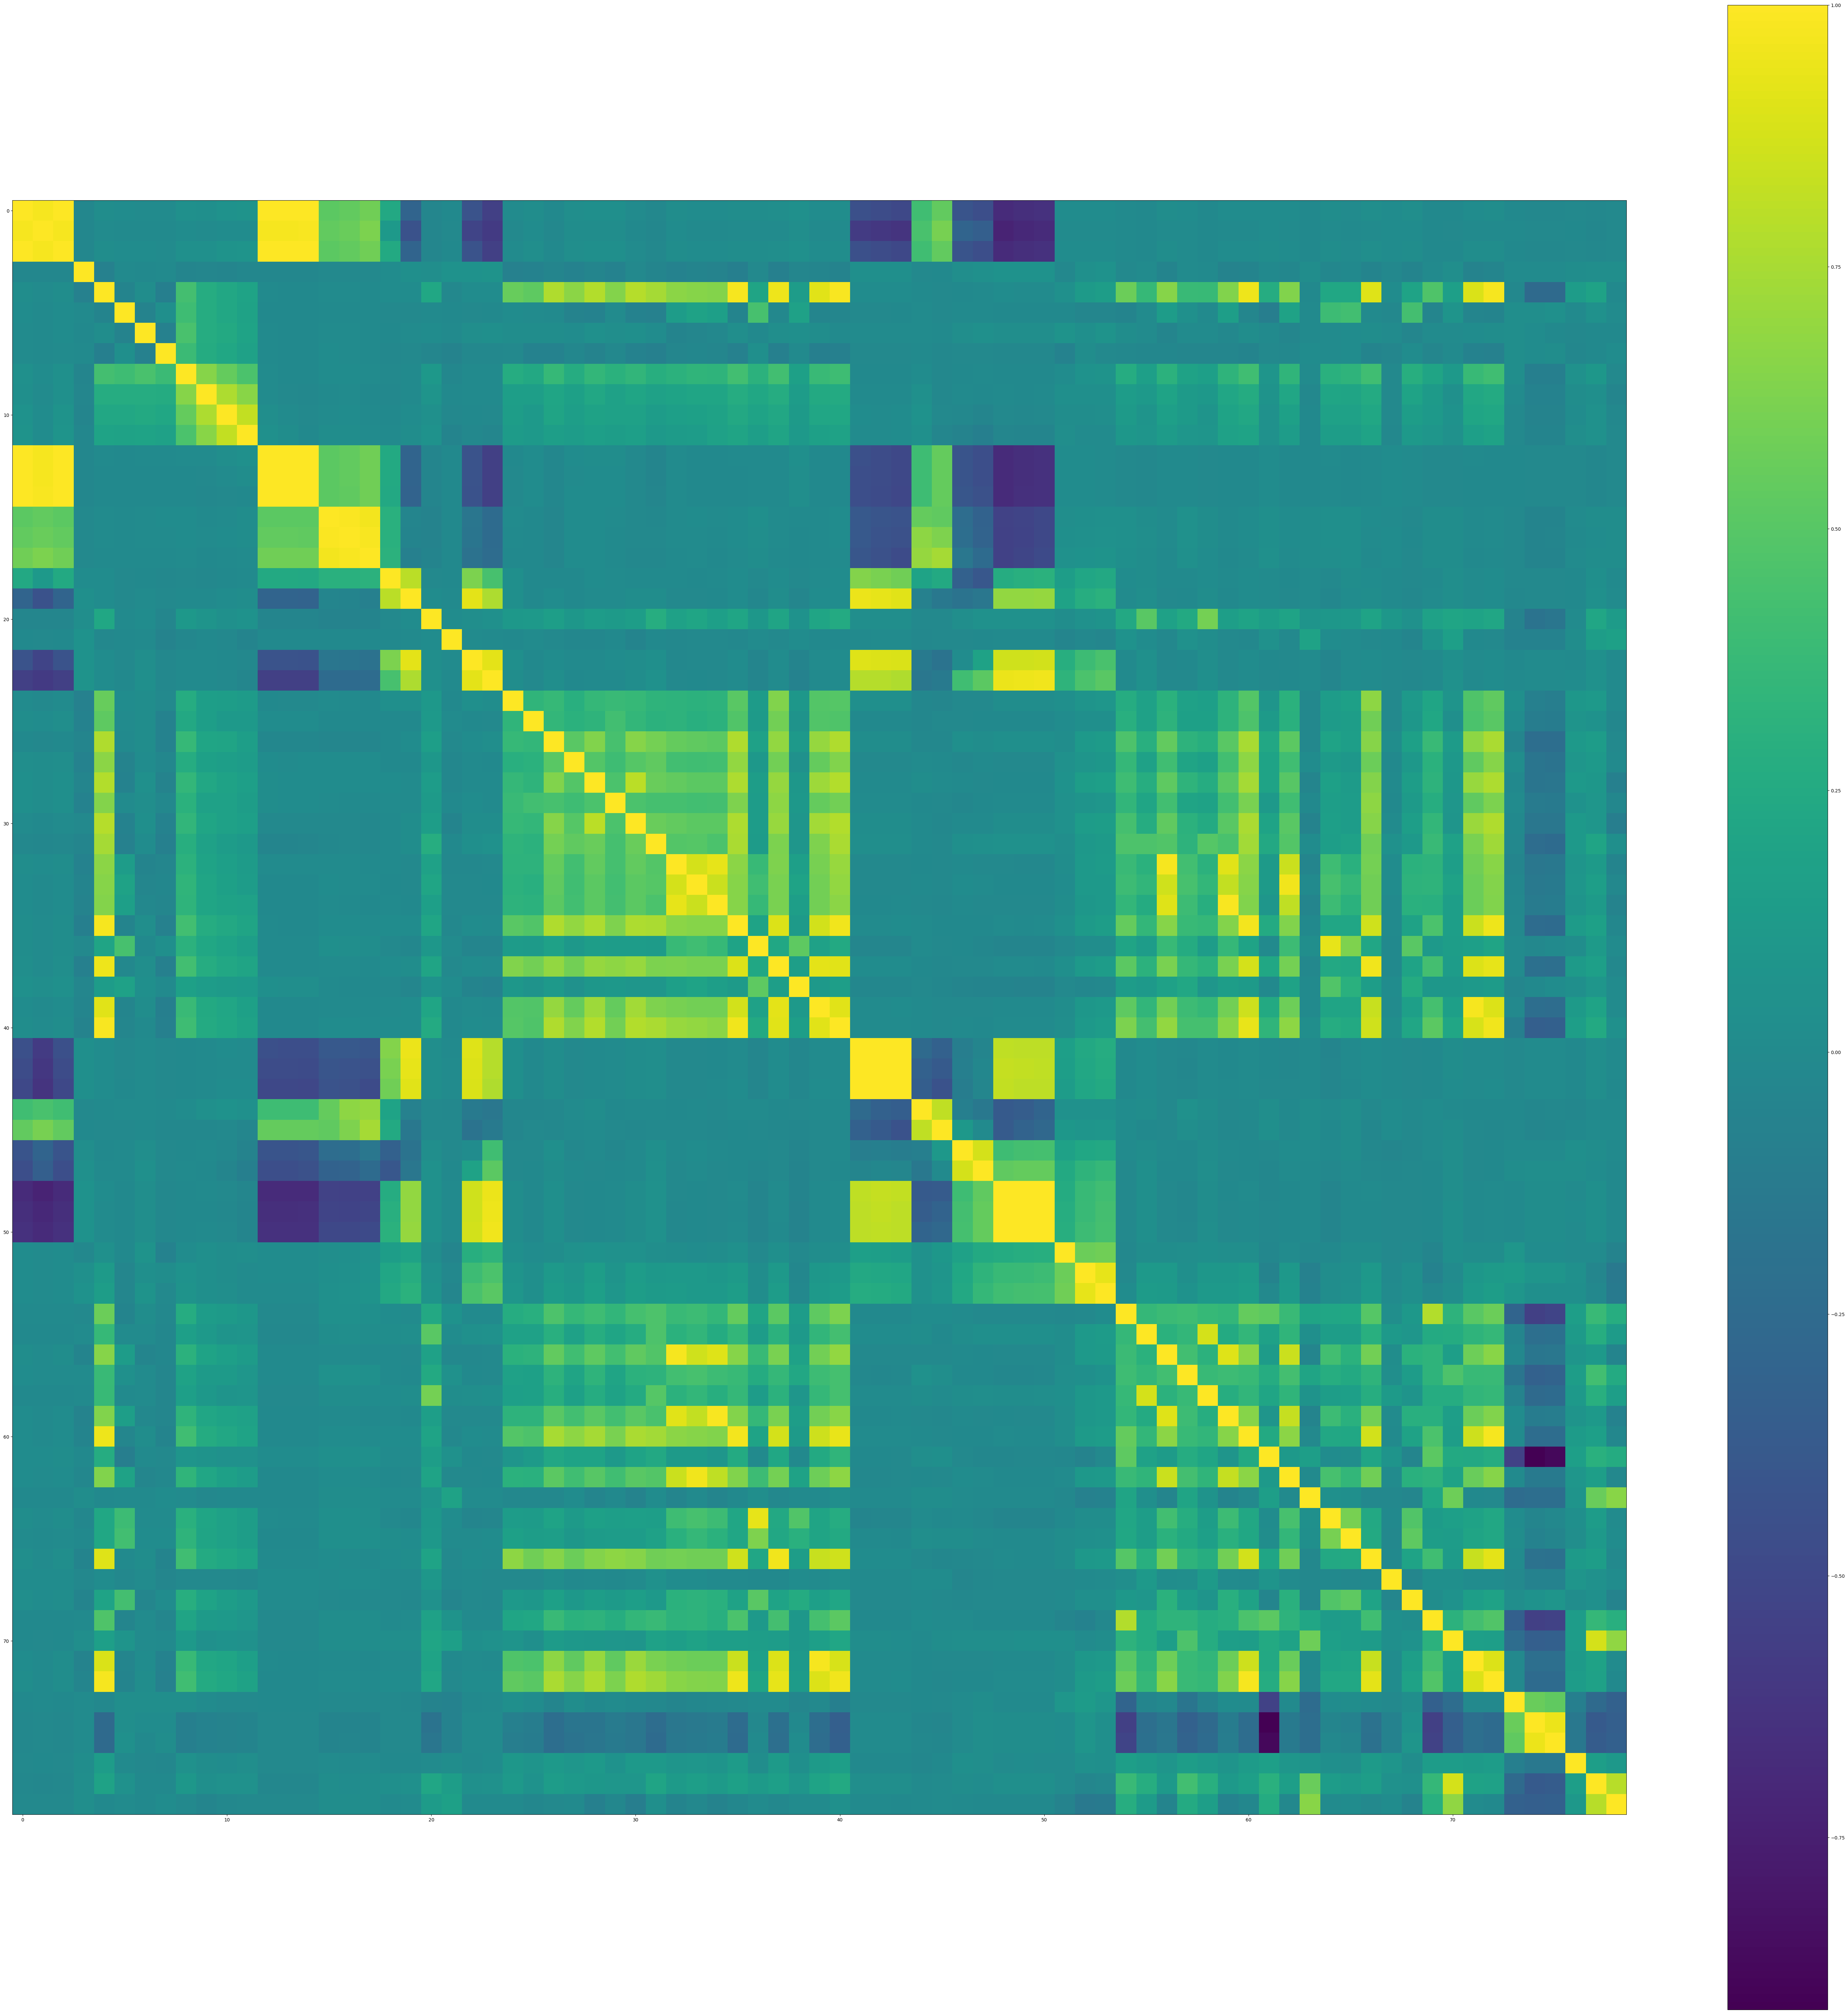

In [17]:
fig, ax = plt.subplots(figsize=(78,78))
im = ax.imshow(market_data.corr(), interpolation='nearest')
fig.colorbar(im, orientation='vertical')

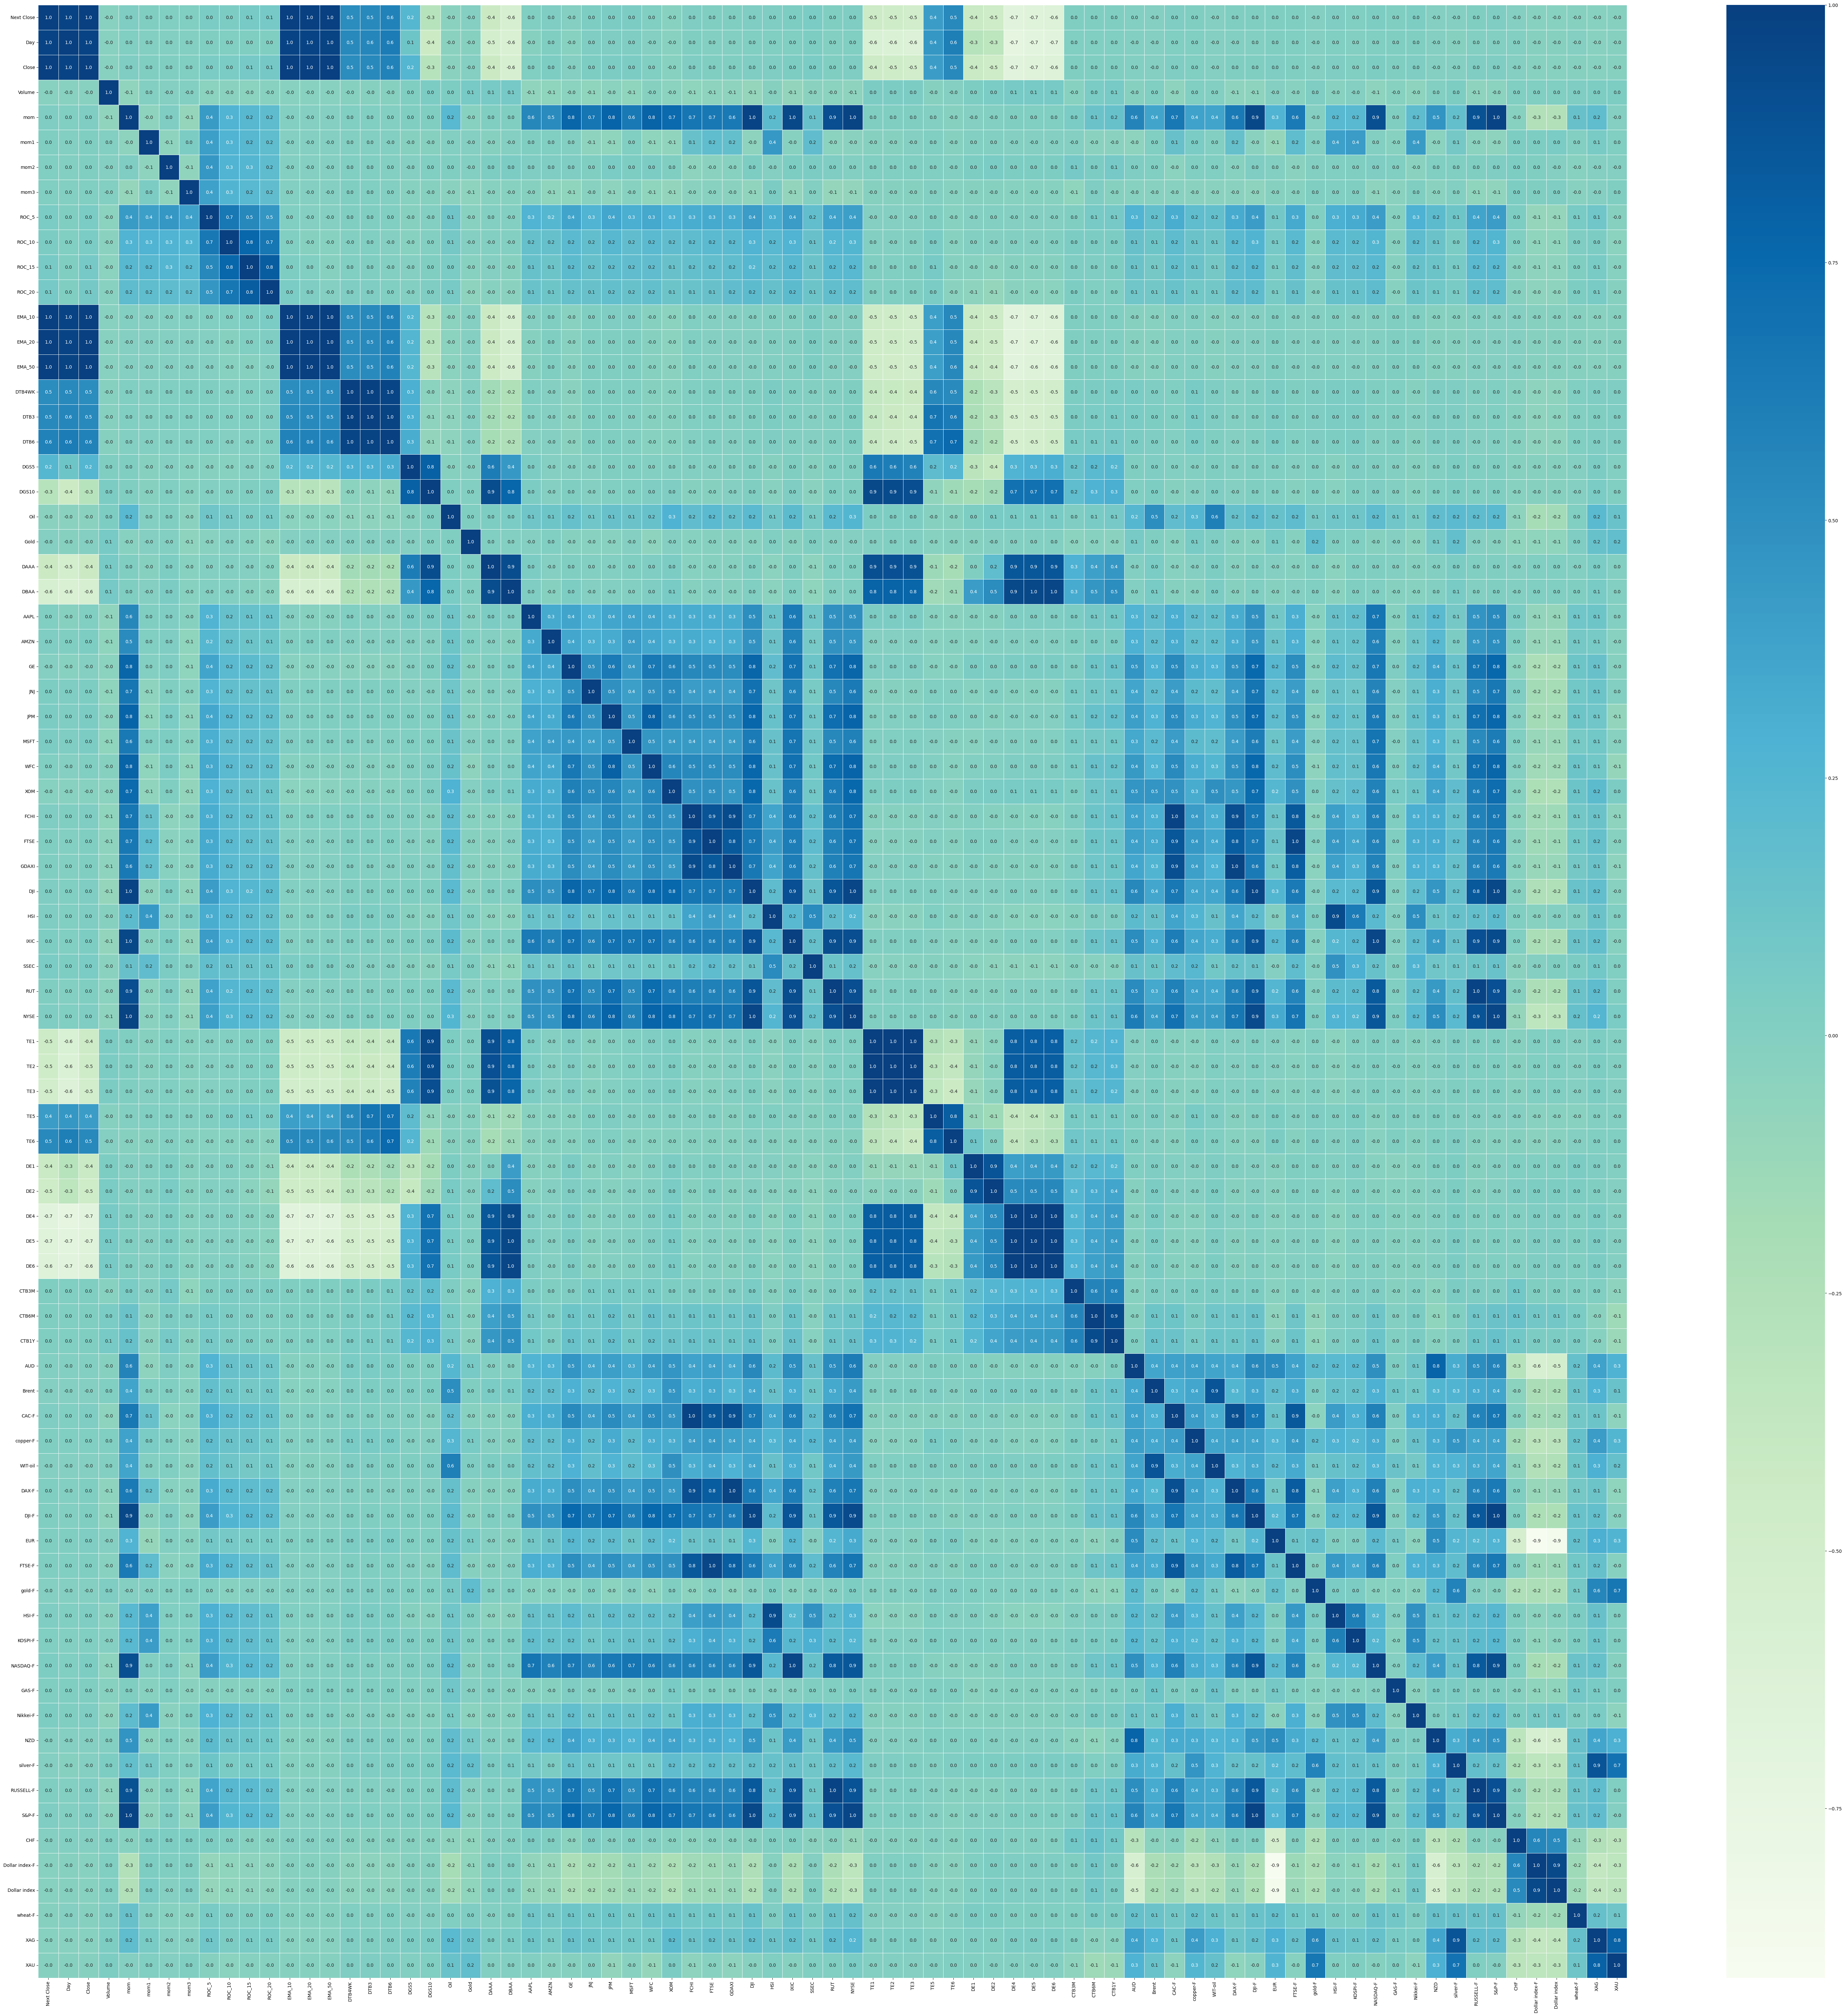

In [18]:
f,ax = plt.subplots(figsize=(78,78))
sns.heatmap(market_data.corr(), cmap="GnBu", annot=True, linewidths=0.5, fmt= '.1f',ax=ax)
plt.show()

Notable Strong Correlations:
1. S&P-F (S&P 500 Futures) and NYSE
2. S&P-F (S&P 500 Futures) and RUT (Russell 2000 Index)
3. S&P-F (S&P 500 Futures) and DJI (Dow Jones Industrial)
4. S&P-F (S&P 500 Futures) and IXIC (Nasdaq Composite)
5. S&P-F (S&P 500 Futures) and GE (General Electric)
6. S&P-F (S&P 500 Futures) and JPM (JP Morgam)
7. S&P-F (S&P 500 Futures) and WFC (Wells Fargo)
8. S&P-F (S&P 500 Futures) and XOM (Exxon Oil)

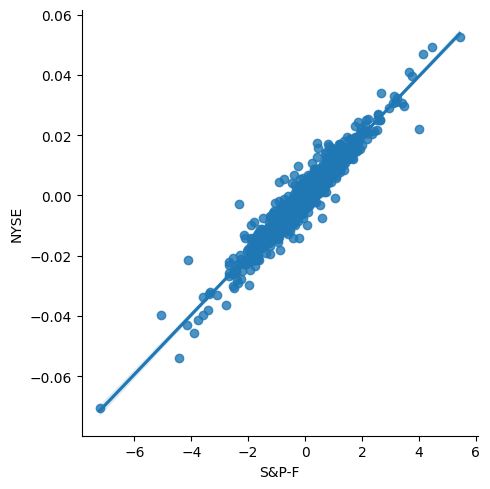

In [19]:
sns.lmplot(
    data=market_data,
    x="S&P-F", y="NYSE"
)

In [20]:
# Shuffle and Split the data into 80% training and 20% testing

train_data, test_data = train_test_split(market_data, test_size=0.2)

# Convert dataframes to back to CSV files and save them locally to the notebook and make sure to exclude the headers so taht Linear Learner will accept the file

train_data.to_csv('train.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

In [21]:
# Copy the file to your S3 bucket using sess.upload_data
# You will need to pass the file to be uploaded, a prefix (top level folder to store the data) and the subfolders
# Here we will also define the output folder for the results

prefix = 'market'
training_data_path = sess.upload_data( path='train.csv', key_prefix=prefix + '/input/train') 
testing_data_path = sess.upload_data( path='test.csv', key_prefix=prefix + '/input/test')
output_data_path = 's3://{}/{}/output'.format(bucket, prefix)
print(training_data_path)
print(testing_data_path)
print(output_data_path)

s3://sagemaker-us-east-1-528179355484/market/input/train/train.csv
s3://sagemaker-us-east-1-528179355484/market/input/test/test.csv
s3://sagemaker-us-east-1-528179355484/market/output


In [22]:
# specify containers

from sagemaker.image_uris import retrieve


# List of frameworks that can be retrieved https://sagemaker.readthedocs.io/en/stable/frameworks/index.html
# list of Built-in Algorithms that can be retrieved https://sagemaker.readthedocs.io/en/stable/algorithms/index.html

container = retrieve('linear-learner', region)

In [23]:
# Amazon Estimator Documentation https://sagemaker.readthedocs.io/en/stable/algorithms/sagemaker.amazon.amazon_estimator.html

from sagemaker.estimator import Estimator 
ll_estimator = Estimator(container, 
                         role=role, 
                         instance_count=1, 
                         instance_type='ml.c4.xlarge', 
                         output_path=output_data_path)

In [24]:
# Set the linear learner hyperparameters
# hyperparameters can be found here https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html
# Here we will use the Hyperameter values for 


ll_estimator.set_hyperparameters(predictor_type='regressor')

In [25]:
# Creating a channel from the S3 data source and file system
# TrainingInput documentation https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html

from sagemaker import TrainingInput 
training_data_channel = TrainingInput( s3_data=training_data_path, content_type='text/csv') 
testing_data_channel = TrainingInput( s3_data=testing_data_path,   content_type='text/csv')

In [26]:
# Hyperparameters = https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html
# Objectives = https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner-tuning.html

from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hypertuner = HyperparameterTuner(ll_estimator, 
                                 objective_metric_name = 'test:absolute_loss',
                                 hyperparameter_ranges = {
                                 'learning_rate' : ContinuousParameter(0.01, 0.1),
                                 'mini_batch_size': CategoricalParameter([32,64,128,256,512])},
                                 objective_type = 'Minimize',
                                 metric_definitions = [{'Name': 'test:absolute_loss', 'Regex': 'loss (\S+)'}],
                                 max_jobs=10, 
                                 max_parallel_jobs=1
                                )

In [27]:
hypertuner.fit( {'train': training_data_channel, 'test': testing_data_channel})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................................................................................!


In [28]:
print("Best hyerparameter tuning job:{}".format(hypertuner.best_training_job()))
print("Best parameters found={}".format(hypertuner.best_estimator().hyperparameters()))

Best hyerparameter tuning job:linear-learner-230216-1657-005-69eb004b

2023-02-16 17:04:59 Starting - Found matching resource for reuse
2023-02-16 17:04:59 Downloading - Downloading input data
2023-02-16 17:04:59 Training - Training image download completed. Training in progress.
2023-02-16 17:04:59 Uploading - Uploading generated training model
2023-02-16 17:04:59 Completed - Resource reused by training job: linear-learner-230216-1657-006-31b1ce93
Best parameters found={'_tuning_objective_metric': 'test:absolute_loss', 'learning_rate': '0.025775585598571148', 'mini_batch_size': '64', 'predictor_type': 'regressor'}


In [29]:
# Set the linear learner hyperparameters
# hyperparameters can be found here https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html
# We will use the values discovered about for learning_rate and mini_batch_size

ll_estimator.set_hyperparameters(feature_dim=78, # There are 78 feature columns
                                 predictor_type='regressor',
                                 mini_batch_size=128,
                                 learning_rate=0.018266315065397474)

In [30]:
# Now we are going to Fit the model
# Documentaiton for FIT https://sagemaker.readthedocs.io/en/stable/algorithms/sagemaker.amazon.amazon_estimator.html#sagemaker.amazon.amazon_estimator.AmazonAlgorithmEstimatorBase.fit

ll_estimator.fit( {'train': training_data_channel, 'test': testing_data_channel})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-02-16-17-08-45-972


2023-02-16 17:08:46 Starting - Starting the training job......
2023-02-16 17:09:31 Starting - Preparing the instances for training...
2023-02-16 17:10:06 Downloading - Downloading input data...
2023-02-16 17:10:32 Training - Downloading the training image.........
2023-02-16 17:12:09 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[02/16/2023 17:11:58 INFO 140340831438656] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1

In [31]:
# Retrieve model data from training job
training_job_model_data = ll_estimator.model_data
training_job_model_data

's3://sagemaker-us-east-1-528179355484/market/output/linear-learner-2023-02-16-17-08-45-972/output/model.tar.gz'

In [32]:
# Create a unique model name so it won't overwrite ones taht are already there using date and time
deployed_linear_model_name = "sp500-market-prediction-model" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name is " + deployed_linear_model_name)

Model name is sp500-market-prediction-model2023-02-16-17-13-00


In [33]:
# Container Definition https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_ContainerDefinition.html

client = boto3.client(service_name="sagemaker")

create_model_response = client.create_model(
    ModelName=deployed_linear_model_name,
    Containers=[
        {
            "Image": container, # use the same container defined in the estimator
            "ModelDataUrl": training_job_model_data
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Model Arn: arn:aws:sagemaker:us-east-1:528179355484:model/sp500-market-prediction-model2023-02-16-17-13-00


In [34]:
sp500_market_epc_name = "linear-learner-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=sp500_market_epc_name,
    ProductionVariants=[
        {
            "VariantName": "llVariant",
            "ModelName": deployed_linear_model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 4096,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:us-east-1:528179355484:endpoint-config/linear-learner-serverless-epc2023-02-16-17-13-00


In [35]:
sp500_market_ep_name = "linear-learner-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=sp500_market_ep_name,
    EndpointConfigName=sp500_market_epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:528179355484:endpoint/linear-learner-serverless-ep2023-02-16-17-13-00


In [36]:
# wait for endpoint to reach a terminal state (InService) using describe endpoint
import time

describe_endpoint_response = client.describe_endpoint(EndpointName=sp500_market_ep_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=sp500_market_ep_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


{'EndpointName': 'linear-learner-serverless-ep2023-02-16-17-13-00',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:528179355484:endpoint/linear-learner-serverless-ep2023-02-16-17-13-00',
 'EndpointConfigName': 'linear-learner-serverless-epc2023-02-16-17-13-00',
 'ProductionVariants': [{'VariantName': 'llVariant',
   'DeployedImages': [{'SpecifiedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1',
     'ResolvedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner@sha256:b9ef174bdf00f15541b9603d24a5d1b16d6c6dc875c13e56e0178a9698014c4c',
     'ResolutionTime': datetime.datetime(2023, 2, 16, 17, 13, 1, 924000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 0,
   'CurrentServerlessConfig': {'MemorySizeInMB': 4096, 'MaxConcurrency': 1}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 2, 16, 17, 13, 0, 989000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 2, 16, 1

In [46]:
runtime = boto3.client(service_name="sagemaker-runtime")

response = runtime.invoke_endpoint(
    EndpointName=sp500_market_ep_name,
    Body="1980,1206,0.072396107,0.00475556,-0.019422767,0.002251387,-0.007738985,-2.654225673,-2.810502424,-3.218023594,-0.054378459,2051.359462,2060.832162,2053.394317,0.12,0.26,0.53,1.66,2.23,0.018513324,-0.003962704,4.01,5.46,-0.006184812,0.027743417,0,0.004622364,0.003121539,0.019977765,-0.002063403,0.022733429,-0.016812666,-0.013220621,-0.019411854,0.005982496,-0.00718416,0.00380255,0.02506475,-0.006897411,0.001013304,2.11,1.97,1.7,0.14,0.41,1.45,3.23,4.93,5.2,5.34,0.038461539,0.102272727,0.064102564,0.79,-0.03,-1.68,-0.19,1.94,-2.02,0.43,0.03,-1.5,-1.13,-0.36,-0.71,0.6,-4.82,-1.93,0.54,-1.97,-0.62,0.44,0.19,-0.08,0.04,0.61,-1.58,-1.12",
    ContentType="text/csv",
)

print(response["Body"].read())

b'{"predictions": [{"score": 1992.1395263671875}]}'


This will need to be trained with more recent data but as functioning it is beneficial as it can predict tomorrow's S&P close based on historic data. If it is significantly lower than todays close that indicates the regression believes the S&P is overvalued and it is not a good time to buy, so potentially sell and take profits is the best course of action. If it is significantly higher than todays close that indicates the regression believes the S&P is undervalued based on historic information, so the best course of action is to buy.

In [47]:
client.delete_model(ModelName=deployed_linear_model_name)
client.delete_endpoint_config(EndpointConfigName=sp500_market_epc_name)
client.delete_endpoint(EndpointName=sp500_market_ep_name)

{'ResponseMetadata': {'RequestId': '48acfec6-789b-476b-aa78-29048ec27a89',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '48acfec6-789b-476b-aa78-29048ec27a89',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 16 Feb 2023 18:04:34 GMT'},
  'RetryAttempts': 0}}